# `pandas` tips for efficient code

In [1]:
# !pip install line_profiler memory_profiler numba

In [1]:
import warnings
%reload_ext autoreload
%autoreload 2
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import timeit
import gc
from tqdm import tqdm
import re
from functools import reduce
import numexpr
from utils.parallel import parallel_df
from utils.processing import find_str_df
import numba as nb
import multiprocessing as mp
%load_ext line_profiler
%load_ext memory_profiler
%load_ext cython
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

pandas version: 1.4.2
numpy version: 1.20.3


In [4]:
def perf_plot(perf_df: pd.DataFrame, title: str) -> None:
    fig, ax = plt.subplots(figsize=(9, 6))
    g = sns.lineplot(
        data=pd.melt(perf_df, id_vars=['data_size'], var_name='method'),
        x='data_size', 
        y='value', 
        hue='method',
        ax=ax
    )
    g.set(yscale='log')
    ax.set_title(title)
    ax.set_xlabel("Data size")
    ax.set_ylabel("Execution time (log scale)")
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
    plt.show()

## Useful magics/functions

These magics are mainly used in profiling code in notebook
- `time`
- `timeit`
- `prun`
- `lprun`
- `memit`

In [4]:
def fib(n):
    """Print the Fibonacci series up to n."""
    a, b = 0, 1
    while b < n:
        print(b, end=' ')
        a, b = b, a + b

    print()

In [5]:
timeit.timeit(lambda: fib(1e6), number=10)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10

0.005695397000003766

In [6]:
%time fib(1000000)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
CPU times: user 403 µs, sys: 81 µs, total: 484 µs
Wall time: 482 µs


In [7]:
%timeit -r 2 -n 1 fib(1e6)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
674 µs ± 10 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [ ]:
%timeit -n 2 fib(1e6)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10

In [8]:
%prun fib(1e6)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
 

         897 function calls in 0.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       62    0.000    0.000    0.000    0.000 socket.py:480(send)
       61    0.000    0.000    0.001    0.000 iostream.py:502(write)
       62    0.000    0.000    0.001    0.000 iostream.py:208(schedule)
       62    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
       31    0.000    0.000    0.001    0.000 {built-in method builtins.print}
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
       61    0.000    0.000    0.000    0.000 iostream.py:420(_is_master_process)
       62    0.000    0.000    0.000    0.000 threading.py:1017(_wait_for_tstate_lock)
       62    0.000    0.000    0.000    0.000 {method 'acquire' of '_thread.lock' objects}
       62    0.000    0.000    0.000    0.000 iostream.py:97(_event_pipe)
       61    0.000    0.000    0.000    0.000 iostream.py:439(_schedule_flush)
 

`prun` components:
- `ncalls`: The number of times the function was called.
- `tottime`: The total time spent in the function (excluding calls to other functions).
- `cumtime`: The time in the function (including other function calls).
- `percall`: The time spent for a single call of the function--it can be obtained by dividing the total or cumulative time by the number of calls.
- `filename:lineno`: The filename and corresponding line numbers. This information is not available when calling C extensions modules.

Usage of `lprun` (from the doc):
```
%lprun -f func1 -f func2 <statement>

The given statement (which doesn't require quote marks) is run via the
LineProfiler. Profiling is enabled for the functions specified by the -f
options. The statistics will be shown side-by-side with the code through the
pager once the statement has completed.

Options:


-f <function>: LineProfiler only profiles functions and methods it is told
to profile.  This option tells the profiler about these functions. Multiple
-f options may be used. The argument may be any expression that gives
a Python function or method object. However, one must be careful to avoid
spaces that may confuse the option parser.

-m <module>: Get all the functions/methods in a module

One or more -f or -m options are required to get any useful results.

-D <filename>: dump the raw statistics out to a pickle file on disk. The
usual extension for this is ".lprof". These statistics may be viewed later
by running line_profiler.py as a script.

-T <filename>: dump the text-formatted statistics with the code side-by-side
out to a text file.

-r: return the LineProfiler object after it has completed profiling.

-s: strip out all entries from the print-out that have zeros.
```

In [11]:
%lprun -f fib fib(1e6)

UsageError: Line magic function `%lprun` not found.


`lprun` components:
- Line #: The number of the line that was run
- Hits: The number of times that line was run
- Time: The execution time of the line in microseconds (Time)
- Per Hit: Time/hits
- % Time: Fraction of the total time spent executing that line
- Line Contents: The content of the line

In [ ]:
%memit fib(1e6)

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 
peak memory: 489.30 MiB, increment: 0.02 MiB


`memit` components:
- `peak memory`: The peak memory usage of the system (including memory usage of other processes) during the program runtime.

- `increment`: is the increment in memory usage relative to the memory usage just before the program is run (i.e. increment = peak memory - starting memory).

## `pandas` tips

### Looping through elements

We have several common methods for looping through a pandas dataframe
- `iterrows`
- `itertuples`
- normal loop

In [174]:
def iterrows_loop(df):
    for i, r in df.iterrows():
        pass

def itertuples_loop(df):
    for r in df.itertuples():
        pass

def py_loop(df):
    for a, b in zip(df['a'], df['b']):
        pass

In [175]:
%%time
perf_df1 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2,8)]):
    df = pd.DataFrame({
        'a': np.random.randint(low=0,high=1e6, size=n),
        'b': np.random.random(size=n)   ,
        'c': np.random.choice([f'cat_{i}' for i in range(1000)], size=n)
    })
    perf_df1 = perf_df1.append({
        "data_size": n,
        "iterrows": timeit.timeit(lambda: iterrows_loop(df), number=1),
        "itertuples": timeit.timeit(lambda: itertuples_loop(df), number=1),
        "normal loop": timeit.timeit(lambda: py_loop(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [05:51<00:00, 58.61s/it] 

CPU times: user 5min 35s, sys: 4.95 s, total: 5min 40s
Wall time: 5min 51s


In [176]:
perf_df1

,data_size,iterrows,itertuples,normal loop
0,100.0,0.002900,0.000465,0.000185
1,1000.0,0.036635,0.001064,0.000428
2,10000.0,0.328415,0.005889,0.001669
3,100000.0,2.971776,0.051108,0.014637
4,1000000.0,27.218675,0.509501,0.138127
5,10000000.0,301.438091,9.832086,4.671988


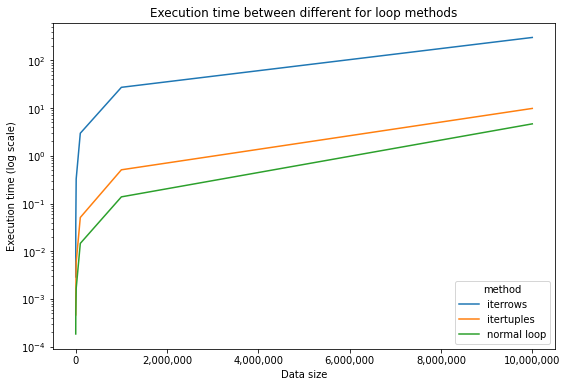

In [177]:
perf_plot(perf_df1, "Execution time between different for loop methods")

Some takeaway points:
- Avoid pure for loop in pandas DataFrame as much as possible (except for string manipulation, will be explained in a later section)
- If you have to do for loops, avoid `iterrows`

### New column assignment

How do we assign new column with values based on the other columns?

In [179]:
df = pd.DataFrame({
    'a': np.random.randint(low=0,high=1e6, size=10**6),
    'b': np.random.random(size=10**6),
    # 'c': np.random.choice([f'cat_{i}' for i in range(1000)], size=n)
  })
df.head()

,a,b
0,24185,0.259541
1,720036,0.580610
2,240883,0.094089
3,641484,0.480012
4,572773,0.083028


Let's say we want to derive a new column `c` from `a` and `b`, and the condition is: 
- If `a * b < 100 and a > 100 and b < 0.5` then `c` is `passed`
- Otherwise `c` is `not passed`

We have can do this in several ways:
- `apply`
- `loc`
- `np.where`
- Python loop

In [8]:
def calculate_c(a,b):
    if a * b < 100 and a > 100 and b < 0.5:
        return 'passed'
    else:
        return 'not passed'
        
def apply_c(df, raw=False):
    df['c'] = df.apply(lambda row: calculate_c(row['a'], row['b']), axis=1, raw=raw)
    return df

def npvectorise_c(df):
    df['c'] = np.vectorize(calculate_c)(df['a'], df['b'])
    return df

def loc_c(df):
    df['c'] = 'not passed'
    df.loc[
        ((df['a'] * df['b'] > 0) & (df['a'] > 100) & (df['b'] < 0.5)),
        'c'
    ] = 'passed'
    return df

def npwhere_c(df):
    df['c'] = np.where(
        ((df['a'] * df['b'] > 0) & (df['a'] > 100) & (df['b'] < 0.5)),
        'passed',
        'not passed'
    )
    return df

def npwhere_val_c(df):
    df['c'] = np.where(
        (
            (df['a'].to_numpy() * df['b'].to_numpy() > 0) &
            (df['a'].to_numpy() > 100) & (df['b'].to_numpy() < 0.5)
        ),
        'passed',
        'not passed'
    )
    return df

def loop_c(df):
    df['c'] = [calculate_c(a, b) for a,b in zip(df['a'], df['b'])]
    return df

In [9]:
%%time
perf_df2 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2,8)]):
    df = pd.DataFrame({
        'a': np.random.randint(low=0, high=1e6, size=n),
        'b': np.random.random(size=n),
        # 'c': np.random.choice([f'cat_{i}' for i in range(1000)], size=n)
    })
    perf_df2 = perf_df2.append({
        "data_size": n,
        "apply": timeit.timeit(lambda: apply_c(df), number=1),
        "np.vectorize": timeit.timeit(lambda: npvectorise_c(df), number=1),
        "loc": timeit.timeit(lambda: loc_c(df), number=1),
        "np.where (with pandas series)": timeit.timeit(lambda: npwhere_c(df), number=1),
        "np.where (with numpy array)": timeit.timeit(lambda: npwhere_val_c(df), number=1),
        "loop": timeit.timeit(lambda: loop_c(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [02:11<00:00, 21.91s/it]

CPU times: user 2min 4s, sys: 3.85 s, total: 2min 8s
Wall time: 2min 11s


In [10]:
perf_df2

,apply,data_size,loc,loop,np.vectorize,np.where (with numpy array),np.where (with pandas series)
0,0.015944,100.0,0.007997,0.000603,0.001480,0.000359,0.002086
1,0.020614,1000.0,0.001726,0.000900,0.001361,0.001035,0.002806
2,0.108195,10000.0,0.002728,0.003585,0.004535,0.001194,0.002182
3,1.165074,100000.0,0.011389,0.037258,0.044648,0.011469,0.014349
4,11.381313,1000000.0,0.060553,0.392866,0.358655,0.106513,0.093435
5,106.148121,10000000.0,0.898073,3.745391,3.705193,1.143533,0.848027


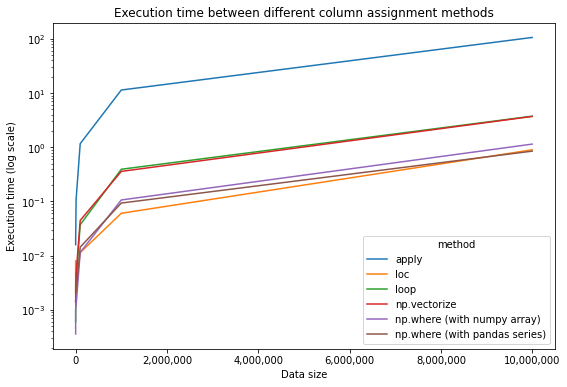

In [17]:
perf_plot(perf_df2, "Execution time between different column assignment methods")

Some takeaways:
- Pythonic looping is more efficient compared to `apply`, as there are more overhead in the method `apply` itself.
- `np.vectorize` has almost identical performance as the tuple-based python loop. As discussed in [this SO question](https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c), that is not true vectorisation. It is also stated in the `numpy` doc.

> Define a vectorized function which takes a nested sequence of objects or numpy arrays as inputs and returns an single or tuple of numpy array as output. The vectorized function evaluates pyfunc over successive tuples of the input arrays like the python map function, except it uses the broadcasting rules of numpy.

> The vectorize function is provided primarily for convenience, not for performance. The implementation is essentially a for loop.
- Use `pandas`/`numpy` built-in vectorised methods wherever possible, as they are generally more efficient for numerical computation.
- Using `np.where` with `numpy` arrays is a little more efficient than with `pandas` series

### Groupby and apply/transform

Let's take a look at a common use case: Normalisation by group. Example is inspired by this [notebook](https://nbviewer.org/github/jreback/pydata2015-london/blob/master/notebooks/idioms.ipynb)

In [180]:
df = pd.DataFrame({
    'cat': np.random.choice([f'cat_{i}' for i in range(1000)], size=10**6),
    'a': np.random.randint(low=0, high=1e6, size=10**6),
})

Suppose we have a dataframe with 2 columns

In [182]:
print(df.head())

       cat       a
0  cat_198  955548
1  cat_727  975060
2  cat_899  883192
3  cat_637  236576
4  cat_440  726605


We would like to normalise the values of `a` by each `cat` and assign the new values to the column `a_normalised`. Let us use min-max scaling.

We compare 3 methods:
- Method 1: groupby + apply
- Method 2: groupby + map
- Method 3: groupby + transform

In [111]:
def groupby_apply_normalise(df):
    df['a_normalised'] = df.groupby('cat')['a'].apply(
        lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), 
    )
    return df

def groupby_map_normalise(df):
    grouped = df.groupby('cat').agg(
        a_min=('a', 'min'),
        a_max=('a', 'max')
    )
    min_val = df['cat'].map(grouped['a_min'])
    max_val = df['cat'].map(grouped['a_max'])
    df['a_normalised'] = (df['a'] - min_val) / (max_val - min_val)
    return df

def unwrap_normalise(df):
    g = df.groupby('cat')['a']
    v = df['a']
    df['a_normalised'] = (v - g.transform('min')) / (g.transform('max') - g.transform('min'))
    return df

In [44]:
%%time
perf_df3 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2, 8)]):
    df = pd.DataFrame({
        'cat': np.random.choice([f'cat_{i}' for i in range(1000)], size=n),
        'a': np.random.randint(low=0, high=1e6, size=n),
    })
    perf_df3 = perf_df3.append({
        "data_size": n,
        "groupby+apply": timeit.timeit(lambda: groupby_apply_normalise(df), number=1),
        "groupby+map": timeit.timeit(lambda: groupby_map_normalise(df), number=1),
        "groupby+transform": timeit.timeit(lambda: unwrap_normalise(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [00:11<00:00,  1.90s/it]

CPU times: user 9.82 s, sys: 1.44 s, total: 11.3 s
Wall time: 11.4 s


In [45]:
perf_df3

,data_size,groupby+apply,groupby+map,groupby+transform
0,100.0,0.062210,0.007735,0.001741
1,1000.0,0.291659,0.007940,0.002664
2,10000.0,0.359748,0.009703,0.002623
3,100000.0,0.411211,0.049122,0.019380
4,1000000.0,0.597881,0.256944,0.089526
5,10000000.0,3.897847,2.371396,0.767930


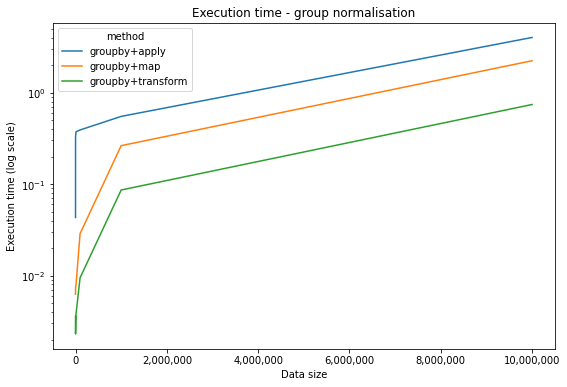

In [26]:
perf_plot(perf_df3, "Execution time - group normalisation")

Sometimes we take the 99th quantile instead of the max value to prevent data skewness. Let us see how the above 3 perform

In [46]:
def groupby_apply_normalise99(df):
    df['a_normalised'] = df.groupby('cat')['a'].apply(
        lambda x: (x - np.min(x)) / (np.quantile(x, 0.99) - np.min(x))
    )
    return df


def groupby_map_normalise99(df):
    grouped = df.groupby('cat').agg(
        a_min=('a', 'min'),
        a_max=('a', lambda x: np.quantile(x, .99))
    )
    min_val = df['cat'].map(grouped['a_min'])
    max_val = df['cat'].map(grouped['a_max'])
    df['a_normalised'] = (df['a'] - min_val) / (max_val - min_val)
    return df


def unwrap_normalise99(df):
    g = df.groupby('cat')['a']
    v = df['a']
    df['a_normalised'] = (v - g.transform('min')) / \
        (g.transform(lambda x: np.quantile(x, .99)) - g.transform('min'))
    return df


In [47]:
%%time
perf_df4 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2, 8)]):
    df = pd.DataFrame({
        'cat': np.random.choice([f'cat_{i}' for i in range(1000)], size=n),
        'a': np.random.randint(low=0, high=1e6, size=n),
    })
    perf_df4 = perf_df4.append({
        "data_size": n,
        "groupby+apply (99th quantile)": timeit.timeit(lambda: groupby_apply_normalise99(df), number=1),
        "groupby+map (99th quantile)": timeit.timeit(lambda: groupby_map_normalise99(df), number=1),
        "groupby+transform (99th quantile)": timeit.timeit(lambda: unwrap_normalise99(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [00:17<00:00,  2.98s/it]

CPU times: user 15.5 s, sys: 1.71 s, total: 17.2 s
Wall time: 17.9 s


In [48]:
perf_df4

,data_size,groupby+apply (99th quantile),groupby+map (99th quantile),groupby+transform (99th quantile)
0,100.0,0.059132,0.024446,0.022638
1,1000.0,0.287979,0.077320,0.122308
2,10000.0,0.485288,0.129774,0.196252
3,100000.0,0.526513,0.169864,0.232615
4,1000000.0,0.709854,0.441034,0.522756
5,10000000.0,4.417838,3.194311,3.981026


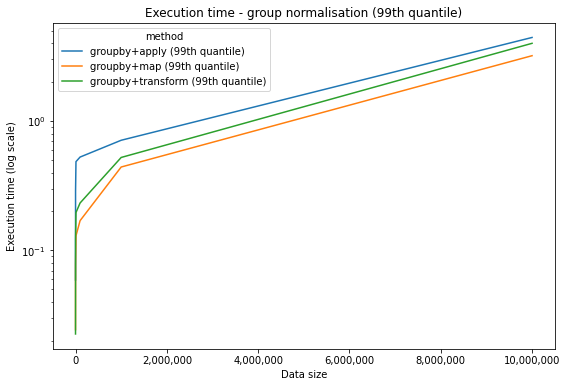

In [49]:
perf_plot(perf_df4, "Execution time - group normalisation (99th quantile)")

In this case, the difference becomes less noticeable. And groupby + map becomes the most efficient in terms of exec time

Since we had to change the default argument to 99th percentile), we could not use the default `optimised` string function of `quantile`. If we use lambda on the max function of `transform`, will the execution time be worse? 

In [50]:
def groupby_apply_lambda(df):
    df['a_normalised'] = df.groupby('cat')['a'].apply(
        lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)),
    )
    return df


def groupby_normalise_lambda(df):
    grouped = df.groupby('cat').agg(
        a_min=('a', 'min'),
        a_max=('a', lambda x: x.max())
    )
    min_val = df['cat'].map(grouped['a_min'])
    max_val = df['cat'].map(grouped['a_max'])
    df['a_normalised'] = (df['a'] - min_val) / (max_val - min_val)
    return df


def unwrap_normalise_lambda(df):
    g = df.groupby('cat')['a']
    v = df['a']
    df['a_normalised'] = (v - g.transform('min')) / \
        (g.transform(lambda x: x.max()) - g.transform('min'))
    return df


In [51]:
%%time
perf_df5 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2, 8)]):
    df = pd.DataFrame({
        'cat': np.random.choice([f'cat_{i}' for i in range(1000)], size=n),
        'a': np.random.randint(low=0, high=1e6, size=n),
    })
    perf_df5 = perf_df5.append({
        "data_size": n,
        "groupby+apply (lambda)": timeit.timeit(lambda: groupby_apply_lambda(df), number=1),
        "groupby+map (lambda)": timeit.timeit(lambda: groupby_normalise_lambda(df), number=1),
        "groupby+transform (lambda)": timeit.timeit(lambda: unwrap_normalise_lambda(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]

CPU times: user 13.8 s, sys: 1.62 s, total: 15.4 s
Wall time: 15.9 s


In [52]:
perf_df5

,data_size,groupby+apply (lambda),groupby+map (lambda),groupby+transform (lambda)
0,100.0,0.047320,0.014245,0.018477
1,1000.0,0.335428,0.052643,0.100104
2,10000.0,0.421685,0.077048,0.153422
3,100000.0,0.399408,0.129211,0.165108
4,1000000.0,0.566843,0.373995,0.495256
5,10000000.0,3.991390,2.983589,3.319806


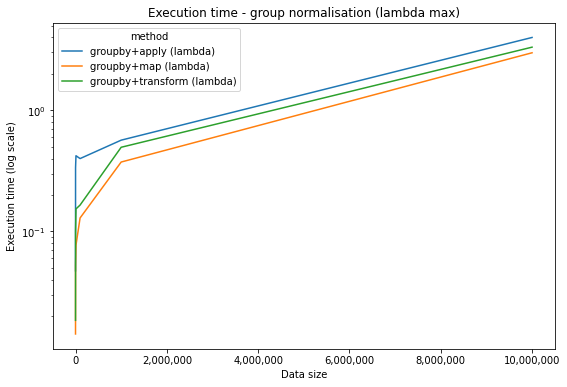

In [53]:
perf_plot(perf_df5, "Execution time - group normalisation (lambda max)")

The same with the quantile case: When we use lambda for max, the differences become much less noticeable. And groupby+transform has worse performance

### Reduce dataframe memory usage 

Function taken from [this article](https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/). The idea is converting the column data types into the minimum required type. 

In [81]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df


In [88]:
df = pd.DataFrame({
    'a': np.random.randint(low=0,high=1e6, size=10**7),
    'b': np.random.random(size=10**7)   ,
    'c': np.random.choice([f'cat_{i}' for i in range(1000)], size=10**7)
})

In [89]:
df.dtypes

a      int64
b    float64
c     object
dtype: object

In [90]:
df = df.pipe(reduce_mem_usage)

Memory usage of dataframe is 228.88 MB
Memory usage after optimization is: 76.33 MB
Decreased by 66.6%


In [91]:
df.dtypes

a       int32
b     float16
c    category
dtype: object

### Categoricals

If we have text categories in the data, or a lot of repeated text then it can be beneficial to convert to pandas Categoricals.

#### Less memory usage

As shown above, the memory usage function converts the object column into category type. Let's see specifically how much memory we could save by doing so.
Example taken from [this article](https://tomaugspurger.github.io/modern-4-performance)

In [109]:
s = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
s_mem = s.memory_usage(index=False) / 1000
print(f's: {s_mem} KB')
c = s.astype('category')
c_mem = c.memory_usage(index=False) / 1000
print(f'c: {c_mem} KB')
print('Decreased by {:.1f}%'.format(100 * (s_mem - c_mem) / s_mem))

s: 800.0 KB
c: 102.52 KB
Decreased by 87.2%


#### Better performance

Let's revisit the groupby example, this time the dataframe category column is converted to category dtype

In [160]:
def groupby_apply_cat(df):
    df['a_normalised'] = df.groupby('cat')['a'].apply(
        lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)),
    )
    return df


def groupby_normalise_cat(df):
    grouped = df.groupby('cat').agg(
        a_min=('a', 'min'),
        a_max=('a', 'max')
    )
    min_val = df['cat'].map(grouped['a_min']).to_numpy()
    max_val = df['cat'].map(grouped['a_max']).to_numpy()
    df['a_normalised'] = (df['a'] - min_val) / (max_val - min_val)
    return df


def unwrap_normalise_cat(df):
    g = df.groupby('cat')['a']
    v = df['a']
    df['a_normalised'] = (v - g.transform('min')) / \
        (g.transform('max') - g.transform('min'))
    return df


In [164]:
%%time
perf_df6 = pd.DataFrame()
for n in tqdm([10 ** i for i in range(2, 8)]):
    df = pd.DataFrame({
        'cat': np.random.choice([f'cat_{i}' for i in range(1000)], size=n),
        'a': np.random.randint(low=0, high=1e6, size=n),
    })
    df['cat'] = df['cat'].astype("category")
    perf_df6 = perf_df6.append({
        "data_size": n,
        "groupby+apply (cat)": timeit.timeit(lambda: groupby_apply_cat(df), number=1),
        "groupby+map (cat)": timeit.timeit(lambda: groupby_normalise_cat(df), number=1),
        "groupby+transform (cat)": timeit.timeit(lambda: unwrap_normalise_cat(df), number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████| 6/6 [00:08<00:00,  1.49s/it]

CPU times: user 7.47 s, sys: 1.25 s, total: 8.72 s
Wall time: 8.93 s


In [169]:
pd.merge(perf_df3, perf_df6, how='inner', on='data_size')

,data_size,groupby+apply,groupby+map,groupby+transform,groupby+apply (cat),groupby+map (cat),groupby+transform (cat)
0,100.0,0.062210,0.007735,0.001741,0.040100,0.022399,0.010174
1,1000.0,0.291659,0.007940,0.002664,0.261610,0.005985,0.001392
2,10000.0,0.359748,0.009703,0.002623,0.400220,0.007118,0.002779
3,100000.0,0.411211,0.049122,0.019380,0.376602,0.009203,0.006207
4,1000000.0,0.597881,0.256944,0.089526,0.468711,0.052102,0.038574
5,10000000.0,3.897847,2.371396,0.767930,3.466366,0.370427,0.308236


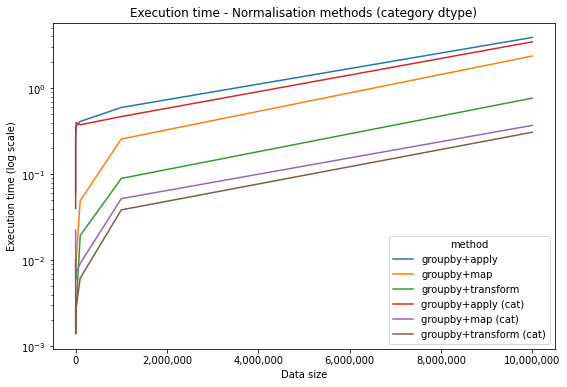

In [170]:
perf_plot(
    pd.merge(perf_df3, perf_df6, how='inner', on='data_size'),
    "Execution time - Normalisation methods"
)

### String operations

Following the above example, can we conclude that vectorised operations in `pandas` are always faster than pythonic loop? 
- According to various sources like [this](https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care) and [this](https://pythonspeed.com/articles/pandas-vectorization/), `pandas`'s `str` operations can often be slower or at least not an improvement compared to Python loops since it will revert back to Python loop in many cases.

For demonstration purpose, we will use an open dataset with text data from [https://archive.ics.uci.edu/ml/machine-learning-databases/00462/](https://archive.ics.uci.edu/ml/machine-learning-databases/00462/). 

```
Data Set Information:

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

Attribute Information:

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

```


In [26]:
# !curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
# !unzip drugsCom_raw.zip

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [2]:
df = pd.read_csv("drugsComTrain_raw.tsv", sep='\t',)

In [10]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [7]:
df.review.str.len().describe()

count    161297.000000
mean        458.726238
std         242.130235
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: review, dtype: float64

In [23]:
df['review2'] = df['review'].str.strip("\"")

In [24]:
df.review2.sample().values

array(['I have been getting several cold sores a year and I am not lucky enough to feel that first tingle. I wake up with a full blown blister! I&#039;ve tried Abreva and several over the counter remedies with no luck. I finally asked my Dr for something stronger and they prescribed Valtrex. I had no luck with that either.\r\nI woke up on a Monday with a huge cold sore blister and took my Valtrex as prescribed with no luck. I saw my Dr again and asked for Denavir because I saw great reviews online. I applied it on Thursday to a very huge, and disgusting, blister every 2 hours as directed and by Sunday the cold sore was gone!! Normally it takes me almost 2 full weeks to get rid of one. This is truly my miracle product! However, it is ridiculously expansive.'],
      dtype=object)

#### String length

In [53]:
%timeit df["review_len"] = df["review2"].str.split().str.len()

827 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
def text_len(s):
    return len(s.split())

In [55]:
%timeit df['review_len2'] = [text_len(s) for s in df['review2']]

770 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
assert (df['review_len'] == df['review_len2']).all()

In [66]:
%%time
perf_df7 = pd.DataFrame()
for i in tqdm([0.01, 0.1, 1, 10, 100]):
    if i < 1:
        df = pd.read_csv("drugsComTrain_raw.tsv", sep='\t',)[['review']].sample(frac=i)
    else:
        df = pd.concat([pd.read_csv("drugsComTrain_raw.tsv", sep='\t',)[['review']]]*i)
    df['review2'] = df['review'].str.strip("\"")
    perf_df7 = perf_df7.append({
        "data_size": df.shape[0],
        "vectorised str": timeit.timeit(lambda: df["review2"].str.split().str.len(), number=1),
        "python loop": timeit.timeit(lambda: [text_len(s) for s in df['review2']], number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [55:15<00:00, 663.18s/it]

CPU times: user 7min 35s, sys: 26min 21s, total: 33min 57s
Wall time: 55min 15s


In [67]:
perf_df7

,data_size,vectorised str,python loop
0,1613.0,0.008589,0.007444
1,16130.0,0.096071,0.078500
2,161297.0,0.931878,0.726394
3,1612970.0,11.944656,7.255283
4,16129700.0,1341.056983,111.311395


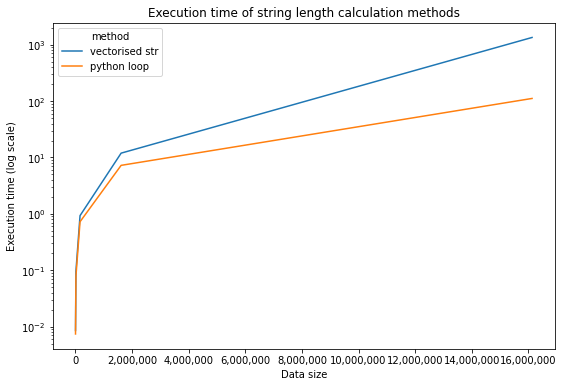

In [68]:
perf_plot(perf_df7, "Execution time of string length calculation methods")

For this use case, we can clearly see that the vectorised approach with `str` accessor is even slower than pure for loop with listcomp.

#### Regex search

Another common use case is regular expression search. Let's say we want to find the price in US dollars in the reviews

In [25]:
%timeit df['price'] = df['review2'].str.extract(r"\$(\d{1,3}(?:\,\d{3})*)\b")

96.4 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
df[df['price'].notnull()].review2.sample().values

array(['Plan B is awesome! I really works, i was freaking out and looking for reviews just like some of you now because, i was on my most fertile days when i had unprotected sex, and i took plan b just two hours later and it worked!!! i got my period the next week after that. \r\r\n*If you have not purchased plan b yet and are unsure go on the website for $10 off coupon before you get it.'],
      dtype=object)

In [11]:
def find_price(s):
    match = re.findall(r"\$(\d{1,3}(?:\,\d{3})*)\b", s)
    if match:
        return match[0]
    return np.nan

In [12]:
%timeit df['price2'] = [find_price(s) for s in df['review2']]

167 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%time
perf_df8 = pd.DataFrame()
for i in tqdm([0.01, 0.1, 1, 10, 100]):
    if i < 1:
        df = pd.read_csv("drugsComTrain_raw.tsv", sep='\t',)[['review']].sample(frac=i)
    else:
        df = pd.concat([pd.read_csv("drugsComTrain_raw.tsv", sep='\t',)[['review']]]*i)
    df['review2'] = df['review'].str.strip("\"")
    perf_df8 = perf_df8.append({
        "data_size": df.shape[0],
        "vectorised str": timeit.timeit(lambda: df['review2'].str.extract(r"\$(\d{1,3}(?:\,\d{3})*)\b"), number=1),
        "python loop": timeit.timeit(lambda: [find_price(s) for s in df['review2']], number=1),
    }, ignore_index=True)
    del df
    gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.61s/it]

CPU times: user 51.5 s, sys: 11.9 s, total: 1min 3s
Wall time: 1min 8s


In [14]:
perf_df8

,data_size,vectorised str,python loop
0,1613.0,0.001848,0.001719
1,16130.0,0.009886,0.017850
2,161297.0,0.097029,0.174782
3,1612970.0,1.328762,2.618416
4,16129700.0,10.095388,17.641346


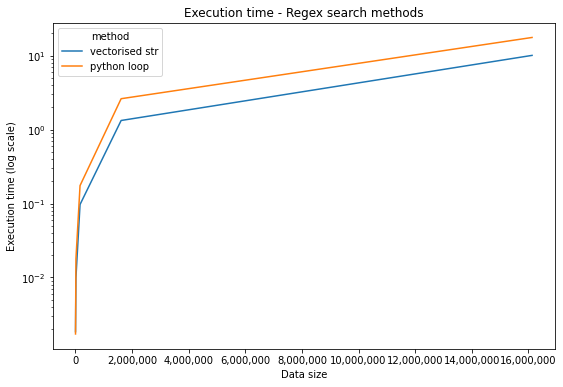

In [15]:
perf_plot(perf_df8, "Execution time - Regex search methods")

In this use case, vectorised string operation is faster in almost every tested data sizes. So vectorised str operations are not necessarily slower than list comp.

### Parallelisation

In [34]:
df_big = pd.concat([df[['review2']]]*100)

In [38]:
%%time
df_big['price'] = df_big['review2'].str.extract(r"\$(\d{1,3}(?:\,\d{3})*)\b")

CPU times: user 7.47 s, sys: 127 ms, total: 7.59 s
Wall time: 7.62 s


In [45]:
# def find_str_df(review):
#     return review.str.extract(r"\$(\d{1,3}(?:\,\d{3})*)\b")

In [56]:
n_jobs = mp.cpu_count()
print(n_jobs)
iterables = np.array_split(df_big['review2'], 8)

8


In [60]:
find_str_df

<function utils.processing.find_str_df(review)>

In [59]:
%%time
df_big['price2'] = parallel_df(
    find_str_df,
    iterables,
    n_jobs,
    2,
    False
)

CPU times: user 4.07 s, sys: 3.66 s, total: 7.73 s
Wall time: 18.5 s


## References

- [https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c](https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c)
- [https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care](https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care)
- [https://github.com/pandas-dev/pandas/issues/35864](https://github.com/pandas-dev/pandas/issues/35864)
- [https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html)
- [https://github.com/mm-mansour/Fast-Pandas](https://github.com/mm-mansour/Fast-Pandas)
- [https://pandas.pydata.org/pandas-docs/version/0.15.0/text.html#text-string-methods](https://pandas.pydata.org/pandas-docs/version/0.15.0/text.html#text-string-methods)
- [https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/](https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/)
- [https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit](https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit)
- [https://pythonspeed.com/articles/pandas-vectorization/](https://pythonspeed.com/articles/pandas-vectorization/)
- [https://jakevdp.github.io/PythonDataScienceHandbook/03.10-working-with-strings.html](https://jakevdp.github.io/PythonDataScienceHandbook/03.10-working-with-strings.html)
- [https://matthewrocklin.com/blog/work/2015/06/18/Categoricals](https://matthewrocklin.com/blog/work/2015/06/18/Categoricals)